# Experiments on Biomedical Data

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from tqdm import tqdm_notebook as tqdm
import random
random.seed(0)

import numpy as np
np.random.seed(0)

from tqdm import tqdm

import cv2 as cv

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


In [8]:
def select_active_rnas_inplace(adata, n_top):
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5,
                                n_top_genes=n_top, inplace=True)
    adata = adata[:, adata.var.highly_variable]
    return adata

In [9]:
celseq_data = sc.read_csv('rna_datasets/celseq2.csv').transpose()
with open('rna_datasets/celseq2_celltype.csv') as f:
    celseq_celltypes = list(map(lambda x: x.strip().replace('_', '-'), f.readlines()))[1:]
celseq_data.obs['type'] = celseq_celltypes

sc.pp.filter_genes(celseq_data, min_cells=25)


In [10]:
celseq_data

AnnData object with n_obs × n_vars = 2285 × 15071
    obs: 'type'
    var: 'n_cells'

In [11]:
smartseq_data = sc.read_csv('rna_datasets/smartseq2.csv').transpose()
with open('rna_datasets/smartseq2_celltype.csv') as f:
    smartseq_celltypes = list(map(lambda x: x.strip().replace('_', '-'), f.readlines()))[1:]
smartseq_data.obs['type'] = smartseq_celltypes

sc.pp.filter_genes(smartseq_data, min_cells=25)

In [12]:
smartseq_data

AnnData object with n_obs × n_vars = 2394 × 17144
    obs: 'type'
    var: 'n_cells'

In [13]:
sc.pp.normalize_total(celseq_data, target_sum=10000)
sc.pp.normalize_total(smartseq_data, target_sum=10000)

In [14]:
sc.pp.log1p(celseq_data)
sc.pp.log1p(smartseq_data)

In [15]:
celseq_data = select_active_rnas_inplace(celseq_data, 5000)
smartseq_data = select_active_rnas_inplace(smartseq_data, 5000)

In [16]:
rna_intersection = list(set(celseq_data.var_names.to_list()).intersection(smartseq_data.var_names.to_list()))

In [17]:
len(rna_intersection)

2808

In [18]:
celseq_cell_vectors = celseq_data[:, rna_intersection]
smartseq_cell_vectors = smartseq_data[:, rna_intersection]

In [19]:
celseq_cell_vectors.shape, smartseq_cell_vectors.shape

((2285, 2808), (2394, 2808))

/home/tigrann/miniconda3/envs/cv/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


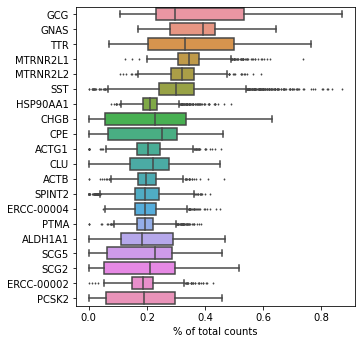

In [18]:
sc.pl.highest_expr_genes(celseq_data, n_top=20, show=False);

# Cell Type Balancing

In [20]:
celseq_cells_by_type = {}
smartseq_cells_by_type = {}

for t, cell in zip(smartseq_celltypes, smartseq_data.obs_names):
    if t not in smartseq_cells_by_type:
        smartseq_cells_by_type[t] = []
    smartseq_cells_by_type[t].append(cell)

for t, cell in zip(celseq_celltypes, celseq_data.obs_names):
    if t not in celseq_cells_by_type:
        celseq_cells_by_type[t] = []
    celseq_cells_by_type[t].append(cell)

In [21]:
for k, v in celseq_cells_by_type.items():
    print(k, len(v), len(smartseq_cells_by_type[k]))

alpha 844 1008
endothelial 21 21
delta 203 127
beta 445 308
ductal 257 444
acinar 274 188
mast 6 7
gamma 110 213
activated-stellate 90 55
macrophage 15 7
quiescent-stellate 12 6
epsilon 4 8
schwann 4 2


In [22]:
for t in celseq_cells_by_type:
    random.shuffle(celseq_cells_by_type[t])
    random.shuffle(smartseq_cells_by_type[t])
    celseq_cells_by_type[t] = celseq_cells_by_type[t][:len(smartseq_cells_by_type[t])]
    smartseq_cells_by_type[t] = smartseq_cells_by_type[t][:len(celseq_cells_by_type[t])]

In [23]:
celseq_cell_type_dict = {}
for k, v in celseq_cells_by_type.items():
    for cell in v:
        celseq_cell_type_dict[cell] = k

In [24]:
smartseq_cell_type_dict = {}
for k, v in smartseq_cells_by_type.items():
    for cell in v:
        smartseq_cell_type_dict[cell] = k

In [25]:
celseq_selected_cells = [cell for v in celseq_cells_by_type.values() for cell in v]
smartseq_selected_cells = [cell for v in smartseq_cells_by_type.values() for cell in v]

random.shuffle(celseq_selected_cells)
random.shuffle(smartseq_selected_cells)

In [26]:
len(celseq_selected_cells), len(smartseq_selected_cells)

(1935, 1935)

In [27]:
celseq_type_balanced_cell_vectors = celseq_data[celseq_selected_cells, rna_intersection]
smartseq_type_balanced_cell_vectors = smartseq_data[smartseq_selected_cells, rna_intersection]
celseq_type_balanced_cell_vectors.shape, smartseq_type_balanced_cell_vectors.shape

((1935, 2808), (1935, 2808))

In [28]:
celseq_cell_vectors = celseq_data[:, rna_intersection]
smartseq_cell_vectors = smartseq_data[:, rna_intersection]

In [29]:
cell_type_indices = {k : i for i, k in enumerate(celseq_cells_by_type.keys())}

In [30]:
cell_type_indices

{'alpha': 0,
 'endothelial': 1,
 'delta': 2,
 'beta': 3,
 'ductal': 4,
 'acinar': 5,
 'mast': 6,
 'gamma': 7,
 'activated-stellate': 8,
 'macrophage': 9,
 'quiescent-stellate': 10,
 'epsilon': 11,
 'schwann': 12}

# Plotting

In [34]:
tmp = sc.AnnData(X = np.concatenate([celseq_type_balanced_cell_vectors.X.toarray(), 
                                     smartseq_type_balanced_cell_vectors.X.toarray()]))

In [35]:
tmp.obs['Cell Type'] = np.zeros(3870)
tmp.obs['Cell Type'][:1935] = celseq_type_balanced_cell_vectors.obs['type']
tmp.obs['Cell Type'][-1935:] = smartseq_type_balanced_cell_vectors.obs['type']

tmp.obs['Dataset'] = 'CEL-seq2'
tmp.obs['Dataset'][:1935] = 'Smart-seq2'

In [36]:
sc.pp.neighbors(tmp, use_rep='X')
sc.tl.umap(tmp)

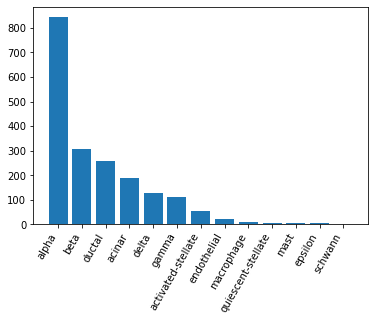

In [37]:
hist_values = {k: len(v) for k, v in celseq_cells_by_type.items()}
sorted_values = sorted([v, k] for k, v in hist_values.items())
plt.bar(range(len(sorted_values)), [v[0] for v in sorted_values[::-1]]);
plt.xticks(range(len(sorted_values)), [v[1] for v in sorted_values[::-1]], rotation=60, ha='right');
# plt.savefig('celseq_smartseq_cell_types.pdf', bbox_inches = 'tight')

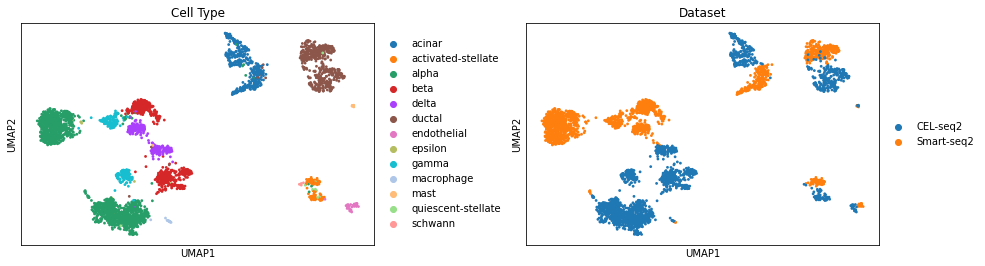

In [38]:
sc.pl.umap(tmp, color=['Cell Type', 'Dataset'], wspace=0.3)

# Matching

In [40]:
def dist(x, y):
    d =  np.linalg.norm(x - y) ** 2
    return d if d > 0 else 1e-10

def greedy(X, X_hash, num_to_match=None, return_cost=False, progress_bar=False):
    costs = [0]
    cost = 0
    if num_to_match is None:
        num_to_match = len(X)
    n, m = len(X), len(X_hash)
    M = np.zeros((n, m))
    if progress_bar:
        iterable = tqdm(enumerate(X), desc='Calculating pairwise distances', total=n)
    else:
        iterable = enumerate(X)
    for i, x in iterable:
        for j, x_hash in enumerate(X_hash):
            M[i, j] = dist(x, x_hash)
    pie = -1 * np.ones(n, dtype=np.int32)
    for _ in range(num_to_match):
        i, j = np.unravel_index(M.argmin(), M.shape)
        pie[i] = j
        cost += M[i, j]
        costs.append(cost)
        M[:, j] = np.inf
        M[i, :] = np.inf

    if return_cost:
        return pie, costs

    return pie

from ortools.graph import pywrapgraph

def MinCostFlow(X, X_hash, num_to_match = None, scale = 1000, sigma=None, return_cost=False):
    n, m = (len(X), len(X_hash))
    M = np.zeros(n * m)
    for i, x in tqdm(enumerate(X), desc='Calculating pairwise distances', total=n):
        for j, x_hash in enumerate(X_hash):
            M[i * m + j] = dist(x, x_hash)
        
    if sigma is not None:
        M = M / 2 / sigma / sigma
    
    min_cost_flow = pywrapgraph.SimpleMinCostFlow()
    
    start_nodes = np.concatenate((np.zeros(n), 
                                  np.repeat(np.arange(1, n + 1), m), 
                                  np.arange(n + 1, n + m + 1))).astype(int).tolist()
    
    end_nodes = np.concatenate((np.arange(1, n + 1), 
                                np.tile(np.arange(n + 1, n + m + 1), n), 
                                np.ones(m) * (n + m + 1))).astype(int).tolist()
    
    num_overall_edges = (n + 1) * (m + 1) - 1
    capacities = np.ones(num_overall_edges).astype(int).tolist()
    costs = (np.concatenate((np.zeros(n), M * scale ,np.zeros(m))).astype(int).tolist())
    
    source = 0
    sink = n + m + 1
    if num_to_match is None:
        num_to_match = n
    
    supplies = [num_to_match] + [0] * (n + m) + [-num_to_match]
    
    # Add each arc.
    for i in range(len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i],
                                                    end_nodes[i], capacities[i],
                                                    costs[i])
    # Add node supplies.
    for i in range(len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])
    
    status = min_cost_flow.Solve()
    assignment = -1 * np.ones(n, dtype=np.int32)
    if status == min_cost_flow.OPTIMAL:
        for arc in range(min_cost_flow.NumArcs()):
            # Can ignore arcs leading out of source or into sink.
            if min_cost_flow.Tail(arc) != source and min_cost_flow.Head(arc) != sink:
                # Arcs in the solution have a flow value of 1. Their start and end nodes
                # give an assignment of worker to task.
                if min_cost_flow.Flow(arc) > 0:
                    assignment[min_cost_flow.Tail(arc) - 1] = min_cost_flow.Head(arc) - n - 1
        
    else:
        print('There was an issue with the min cost flow input.')
        print(f'Status: {status}')

    if return_cost:
        return assignment, min_cost_flow.OptimalCost() / scale
    else:
        return assignment



## Experiment 1 (No Outliers)

In [41]:
X = celseq_type_balanced_cell_vectors.to_df().values
X_hash = smartseq_type_balanced_cell_vectors.to_df().values

In [42]:
print(X.shape, X_hash.shape)

(1935, 2808) (1935, 2808)


In [43]:
matching = MinCostFlow(X, X_hash, return_cost=False)

Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1935/1935 [00:44<00:00, 43.25it/s]


In [44]:
y_cel, y_smart = [], []
for cel, smart in enumerate(matching):
    y_cel.append(celseq_cell_type_dict[celseq_selected_cells[cel]])
    y_smart.append(smartseq_cell_type_dict[smartseq_selected_cells[smart]])

In [45]:
cm = confusion_matrix([cell_type_indices[tp] for tp in y_cel],
                      [cell_type_indices[tp] for tp in y_smart], normalize='true')
cm = (cm * 100).astype(np.int32)

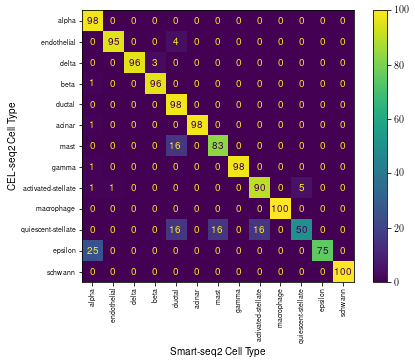

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ConfusionMatrixDisplay(cm).plot(values_format='d', ax=ax, xticks_rotation='vertical');

ax.set_yticklabels(map(lambda r: r.replace('_', '-'), cell_type_indices.keys()), size=7)
ax.set_xticklabels(map(lambda r: r.replace('_', '-'), cell_type_indices.keys()), size=7)
ax.set_xlabel('Smart-seq2 Cell Type', size=10)
ax.set_ylabel('CEL-seq2 Cell Type', size=10);
# fig.savefig('celseq_smartseq_confusion_matrics.pdf', bbox_inches = 'tight')

In [48]:
print(accuracy_score(y_cel, y_smart))

0.9741602067183462


## Experiment 2 (Outlier cell types in **both sets**, estimation of the number of inliers)

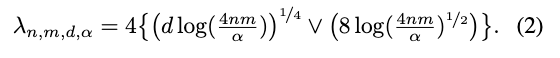

In [56]:
def lambda_nmda(n, m, d, alpha = 0.01):
    return 4 * max(np.power(d * np.log(4 * n * m / alpha), 1 / 4),
                   np.power(8 * np.log(4 * n * m / alpha), 1 / 2) )

def k_sig_joint_est(X, X_hash, progress_bar=True, matcher=greedy):
    n = len(X)
    m = len(X_hash)
    d = len(X[0])
    lambda_nmd = lambda_nmda(n, m, d)
    lbd = np.square(lambda_nmd) / 4
    gamma = lbd / d
    res = {}
    
    _, costs = matcher(X, X_hash, num_to_match=n, return_cost=True, progress_bar=progress_bar)
    
    for k in range(1, n - 1):
        sigma_hat_sq = costs[k] / (k) / d
        if costs[k + 1] - costs[k] > (d + lbd) * sigma_hat_sq / (1 - gamma):
            break
            
    res['k_alpha'] = k
    res['sigma_hat'] = np.sqrt(sigma_hat_sq / 2)
    return res

In [58]:
types_to_remove = ['delta', 'beta', 'ductal', 'acinar', 'gamma']
for type_cell in types_to_remove:
    for type_smart in types_to_remove:
        if type_cell == type_smart:
            continue
        X = celseq_type_balanced_cell_vectors.to_df().values[celseq_type_balanced_cell_vectors.obs['type'] != type_cell]
        X_hash = smartseq_type_balanced_cell_vectors.to_df().values[smartseq_type_balanced_cell_vectors.obs['type'] != type_smart]
        true_k = len(celseq_type_balanced_cell_vectors) - len(celseq_cells_by_type[type_cell]) - len(smartseq_cells_by_type[type_smart])
        res = k_sig_joint_est(X, X_hash, progress_bar=True)
        print(f'Results for Types  ---  {type_cell} : {type_smart}')
        print(f'Set Sizes  ---  {len(X)} : {len(X_hash)}')
        print(f'True Number of Inliers = {true_k} ')
        print(f'Predictions = {res}')

        


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1808/1808 [00:34<00:00, 52.34it/s]


Results for Types  ---  delta : beta
Set Sizes  ---  1808 : 1627
True Number of Inliers = 1500 
Predictions = {'k_alpha': 1593, 'sigma_hat': 0.3092298378093878}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1808/1808 [00:36<00:00, 49.68it/s]


Results for Types  ---  delta : ductal
Set Sizes  ---  1808 : 1678
True Number of Inliers = 1551 
Predictions = {'k_alpha': 1543, 'sigma_hat': 0.2992985117755967}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1808/1808 [00:38<00:00, 47.55it/s]


Results for Types  ---  delta : acinar
Set Sizes  ---  1808 : 1747
True Number of Inliers = 1620 
Predictions = {'k_alpha': 1595, 'sigma_hat': 0.30735612611618857}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1808/1808 [00:39<00:00, 45.67it/s]


Results for Types  ---  delta : gamma
Set Sizes  ---  1808 : 1825
True Number of Inliers = 1698 
Predictions = {'k_alpha': 1768, 'sigma_hat': 0.309470210822294}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1627/1627 [00:35<00:00, 46.27it/s]


Results for Types  ---  beta : delta
Set Sizes  ---  1627 : 1808
True Number of Inliers = 1500 
Predictions = {'k_alpha': 1589, 'sigma_hat': 0.3093110997900585}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1627/1627 [00:31<00:00, 51.44it/s]


Results for Types  ---  beta : ductal
Set Sizes  ---  1627 : 1678
True Number of Inliers = 1370 
Predictions = {'k_alpha': 1361, 'sigma_hat': 0.29697559128273554}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1627/1627 [00:32<00:00, 50.60it/s]


Results for Types  ---  beta : acinar
Set Sizes  ---  1627 : 1747
True Number of Inliers = 1439 
Predictions = {'k_alpha': 1414, 'sigma_hat': 0.30633011472701954}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1627/1627 [00:33<00:00, 47.91it/s]


Results for Types  ---  beta : gamma
Set Sizes  ---  1627 : 1825
True Number of Inliers = 1517 
Predictions = {'k_alpha': 1588, 'sigma_hat': 0.3079923841468354}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1678/1678 [00:35<00:00, 47.57it/s]


Results for Types  ---  ductal : delta
Set Sizes  ---  1678 : 1808
True Number of Inliers = 1551 
Predictions = {'k_alpha': 1546, 'sigma_hat': 0.3014558540218777}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1678/1678 [00:31<00:00, 52.68it/s]


Results for Types  ---  ductal : beta
Set Sizes  ---  1678 : 1627
True Number of Inliers = 1370 
Predictions = {'k_alpha': 1366, 'sigma_hat': 0.298870254993283}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1678/1678 [00:33<00:00, 50.33it/s]


Results for Types  ---  ductal : acinar
Set Sizes  ---  1678 : 1747
True Number of Inliers = 1490 
Predictions = {'k_alpha': 1556, 'sigma_hat': 0.3070991923964168}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1678/1678 [00:34<00:00, 48.16it/s]


Results for Types  ---  ductal : gamma
Set Sizes  ---  1678 : 1825
True Number of Inliers = 1568 
Predictions = {'k_alpha': 1561, 'sigma_hat': 0.29963502698872624}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1747/1747 [00:35<00:00, 48.95it/s]


Results for Types  ---  acinar : delta
Set Sizes  ---  1747 : 1808
True Number of Inliers = 1620 
Predictions = {'k_alpha': 1612, 'sigma_hat': 0.30976454183291224}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1747/1747 [00:32<00:00, 54.06it/s]


Results for Types  ---  acinar : beta
Set Sizes  ---  1747 : 1627
True Number of Inliers = 1439 
Predictions = {'k_alpha': 1432, 'sigma_hat': 0.3084193121334245}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1747/1747 [00:32<00:00, 52.96it/s]


Results for Types  ---  acinar : ductal
Set Sizes  ---  1747 : 1678
True Number of Inliers = 1490 
Predictions = {'k_alpha': 1588, 'sigma_hat': 0.3089906113848334}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1747/1747 [00:35<00:00, 48.56it/s]


Results for Types  ---  acinar : gamma
Set Sizes  ---  1747 : 1825
True Number of Inliers = 1637 
Predictions = {'k_alpha': 1630, 'sigma_hat': 0.30825112962872875}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1825/1825 [00:37<00:00, 48.50it/s]


Results for Types  ---  gamma : delta
Set Sizes  ---  1825 : 1808
True Number of Inliers = 1698 
Predictions = {'k_alpha': 1773, 'sigma_hat': 0.3106672783465567}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1825/1825 [00:34<00:00, 52.92it/s]


Results for Types  ---  gamma : beta
Set Sizes  ---  1825 : 1627
True Number of Inliers = 1517 
Predictions = {'k_alpha': 1593, 'sigma_hat': 0.30866448159411364}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1825/1825 [00:35<00:00, 51.12it/s]


Results for Types  ---  gamma : ductal
Set Sizes  ---  1825 : 1678
True Number of Inliers = 1568 
Predictions = {'k_alpha': 1559, 'sigma_hat': 0.29853191890762926}


Calculating pairwise distances: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1825/1825 [00:36<00:00, 49.61it/s]


Results for Types  ---  gamma : acinar
Set Sizes  ---  1825 : 1747
True Number of Inliers = 1637 
Predictions = {'k_alpha': 1612, 'sigma_hat': 0.30665448983829374}
